<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson22_RecSys/ML_AI_recsys2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекомендательные системы

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

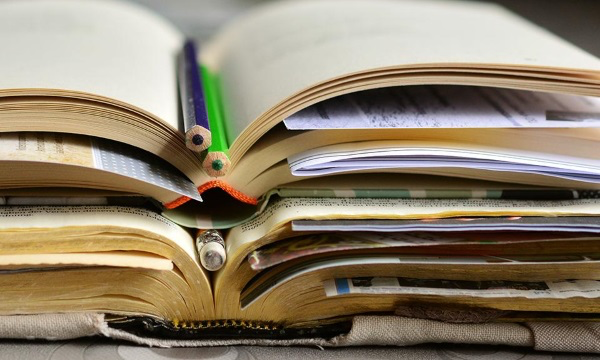

In [ ]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

## Часть 1. Загрузка данных

Загрузим Deskdrop dataset, включающийся в себе информацию за один год платформы, где пользователи читают статьи.

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [ ]:
articles_df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/shared_articles.csv")

articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

timestamp       eventType            contentId       authorPersonId  \
1  1459193988  CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146  CONTENT SHARED -7292285110016212249  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
1  8940341205206233829             NaN          NaN           NaN        HTML   
2  8940341205206233829             NaN          NaN           NaN        HTML   

                                                 url  \
1  http://www.nytimes.com/2016/03/28/business/dea...   
2  http://cointelegraph.com/news/bitcoin-future-w...   

                                               title  \
1  Ethereum, a Virtual Currency, Enables Transact...   
2  Bitcoin Future: When GBPcoin of Branson Wins O...   

                                                text lang  
1  All of this work is still very early. The firs...   en  
2  The alarm clock wakes me at 8:00 with stream o...   en

#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [ ]:
interactions_df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/users_interactions.csv')
interactions_df.head()

timestamp eventType            contentId             personId  \
0  1465413032      VIEW -3499919498720038879 -8845298781299428018   
1  1465412560      VIEW  8890720798209849691 -1032019229384696495   
2  1465416190      VIEW   310515487419366995 -1130272294246983140   
3  1465413895    FOLLOW   310515487419366995   344280948527967603   
4  1465412290      VIEW -7820640624231356730  -445337111692715325   

             sessionId                                          userAgent  \
0  1264196770339959068                                                NaN   
1  3621737643587579081  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
2  2631864456530402479                                                NaN   
3 -3167637573980064150                                                NaN   
4  5611481178424124714                                                NaN   

  userRegion userCountry  
0        NaN         NaN  
1         NY          US  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN

In [ ]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [ ]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [ ]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [ ]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('number of users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('number of users with at least 5 interactions:',len(users_with_enough_interactions_df))

number of users: 1895
number of users with at least 5 interactions: 1140


<Axes: >

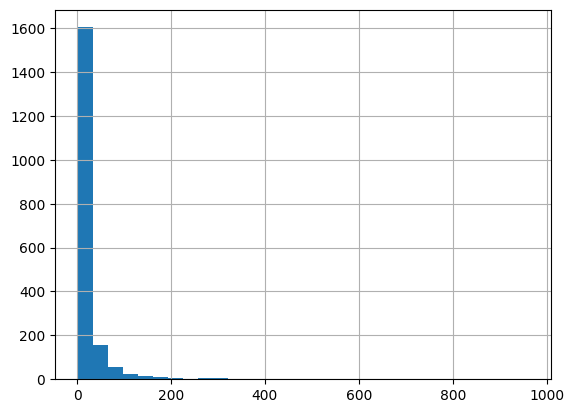

In [ ]:
users_interactions_count_df.hist(bins=30)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [ ]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [ ]:
print('number of interactions before:', interactions_df.shape)
print('number of interactions after:', interactions_from_selected_users_df.shape)

number of interactions before: (72312, 9)
number of interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьей более одного раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов.

Однако полученное число будет в том числе тем больше, чем больше действий произвел человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)

interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head()

personId             contentId  eventStrength  last_timestamp
0  -1007001694607905623  -5065077552540450930       1.000000      1470395911
1  -1007001694607905623  -6623581327558800021       1.000000      1487240080
2  -1007001694607905623   -793729620925729327       1.000000      1472834892
3  -1007001694607905623   1469580151036142903       1.000000      1487240062
4  -1007001694607905623   7270966256391553686       1.584963      1485994324

Разобьём выборку на обучение и контроль по времени.

In [ ]:
split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('number of interactions on Train set: %d' % len(interactions_train_df))
print('number of interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

number of interactions on Train set: 29329
number of interactions on Test set: 9777


personId             contentId  eventStrength  \
0      -1007001694607905623  -5065077552540450930            1.0   
2      -1007001694607905623   -793729620925729327            1.0   
6      -1032019229384696495  -1006791494035379303            1.0   
7      -1032019229384696495  -1039912738963181810            1.0   
8      -1032019229384696495  -1081723567492738167            2.0   
...                     ...                   ...            ...   
39099    997469202936578234   9112765177685685246            2.0   
39100    998688566268269815  -1255189867397298842            1.0   
39101    998688566268269815   -401664538366009049            1.0   
39103    998688566268269815   6881796783400625893            1.0   
39105    998688566268269815    739747367187387064            1.0   

       last_timestamp  
0          1470395911  
2          1472834892  
6          1469129122  
7          1459376415  
8          1464054093  
...               ...  
39099      1472479493  
39100      1474567164  
39101      1474567449  
39103      1474567675  
39105      1474567514  

[29329 rows x 4 columns]

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [ ]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

true_train  \
personId                                                                  
-1007001694607905623        [-5065077552540450930, -793729620925729327]   
-1032019229384696495  [-1006791494035379303, -1039912738963181810, -...   
-108842214936804958   [-1196068832249300490, -133139342397538859, -1...   
-1130272294246983140  [-1150591229250318592, -1196068832249300490, -...   
-1160159014793528221  [-133139342397538859, -387651900461462767, 377...   

                                                              true_test  
personId                                                                 
-1007001694607905623  [-6623581327558800021, 1469580151036142903, 72...  
-1032019229384696495  [-1415040208471067980, -2555801390963402198, -...  
-108842214936804958   [-2780168264183400543, -3060116862184714437, -...  
-1130272294246983140  [-1606980109000976010, -1663441888197894674, -...  
-1160159014793528221                             [-3462051751080362224]

## Метрика качества

Качество модели будем оценивать при помощи метрики precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним ее по всем пользователям.

In [ ]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

## Часть 2. Коллаборативная фильтрация.

Применим коллаборативную фильтрацию для построения рекомендаций.

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [ ]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

Посчитаем схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [ ]:
ratings_m = ratings.values

In [ ]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):

        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)

        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue

        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]

        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

<ipython-input-18-71be133d8340>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings_m)-1)):


  0%|          | 0/1111 [00:00<?, ?it/s]

Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитаем качество по той же метрике.

In [ ]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0

    if sum(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

<ipython-input-19-0e4cd4466ec4>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(similarity_users))):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [ ]:
calc_precision('prediction_user_based')

0.002567712663134835

## Часть 3. SVD-разложение

Реализуем подход с разложением матрицы оценок. Для этого сделаем сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы.

In [ ]:
from scipy.linalg import svd

In [ ]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [ ]:
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

1.0442629028233364e-24


Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице U, оставить из sigma только первые 100 значений (и сделать из них диагональную матрицу) и 100 столбцов в матрице V. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [ ]:
K = 100

sigma[K:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

Посчитаем качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравним его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [ ]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

25843.42489891278
78622.13000466184


Теперь можно делать предсказания по матрице. Сделаем их (не забываем про то, что уже было просмотрено пользователем), оценим качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [ ]:
top_k = 10

new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )

    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

<ipython-input-26-0ed0dd1218b9>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [ ]:
calc_precision('prediction_svd')

0.012212989310270756

## Часть 4: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы.

Реализуем её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитаем популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируем материалы по их популярности.

In [ ]:
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)

In [ ]:
print(articles_df.loc[articles_df.contentId == popular_content[2]]['title'].values)

["Ray Kurzweil: The world isn't getting worse - our information is getting better"]


In [ ]:
print(articles_df.loc[articles_df.contentId == popular_content[2363]]['title'].values)

['Sunset Blvd. (1950)']


Теперь необходимо сделать предсказания для каждого пользователя. Не забываем, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [ ]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

interactions['prediction_popular'][0]

<ipython-input-31-3cd203b27dd4>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  interactions['prediction_popular'][0]


array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

In [ ]:
calc_precision('prediction_popular')

0.006454207722621089